<a href="https://colab.research.google.com/github/ptripathi/NLP/blob/master/models/model4/testv4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Testing the encoder-decoder model

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
from __future__ import absolute_import, division, print_function

!pip install tensorflow-gpu==2.0.0-alpha0

In [0]:
import os
import sys
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

import re
import numpy as np
import os
import time
import pickle

In [4]:
print(tf.__version__)

2.0.0-alpha0


In [0]:
current_path = os.path.abspath(os.path.join('.'))
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [0]:
dataset_save_location = "/content/gdrive/My Drive/W266/Project/data/parallel_trainv4.p"

In [0]:
import data_prep;
import utils;
import encoder;
import attention;
import decoder;

In [8]:
X_all, Y_all, en_word2idx_all, en_idx2word_all, en_vocab_all, hi_word2idx_all, hi_idx2word_all, hi_vocab_all = utils.load_pickle_dataset(dataset_save_location)
len(X_all), len(Y_all), len(en_vocab_all), len(hi_vocab_all)

(696695, 696695, 50004, 50004)

In [0]:
emb_dim = 100
embedding_weights = utils.load_glove_embeddings("/content/gdrive/My Drive/W266/Project/data/glove.6B/", len(en_vocab_all), en_word2idx_all, emb_dim)

In [10]:
max_length_inp = utils.max_length(X_all) + 2 # <start>, <end>
max_length_tar = utils.max_length(Y_all) + 2 # <start>, <end>
(max_length_inp, max_length_tar)

(17, 17)

In [0]:
BATCH_SIZE = 64
embedding_dim = 100
units = 1024
vocab_inp_size = len(en_vocab_all)
vocab_tar_size = len(hi_vocab_all)

In [0]:
from encoder import Encoder
from decoder import Decoder
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE, weights_ = embedding_weights,mask=1)
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

In [0]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask
  
  return tf.reduce_mean(loss_)

In [0]:
checkpoint_dir = '/content/gdrive/My Drive/W266/Project/training_checkpoints_v4'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [0]:
def evaluate(sentence, encoder, decoder, max_length_inp, max_length_targ):
    attention_plot = np.zeros((max_length_targ, max_length_inp))
    
    sentence = '<start> ' + sentence.lower() + ' <end>'
    
    inputs = [en_word2idx_all[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs], maxlen=max_length_inp, padding='post')
    
    # reverse
    inputs = inputs[...,::-1]
    
    inputs = tf.convert_to_tensor(inputs)
    
    result = ''
    
    hidden = [tf.zeros((1,units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([hi_word2idx_all['<start>']], 0)
    
    
    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input, dec_hidden, enc_out)
        
        # storing the attention weigths to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        
        result += hi_idx2word_all[predicted_id] + ' '

        if hi_idx2word_all[predicted_id] == '<end>':
            return result, sentence, attention_plot
        
        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

In [0]:
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')
    
    fontdict = {'fontsize': 14}
    hindi_font = FontProperties(fname = '/content/gdrive/My Drive/W266/Project/gargi.ttf')
    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict, fontproperties=hindi_font)

    plt.show()

In [0]:
def translate(sentence, encoder, decoder, max_length_inp, max_length_targ):
    result, sentence, attention_plot = evaluate(sentence, encoder, decoder, max_length_inp, max_length_targ)
        
    print('Input: {}'.format(sentence))
    print('Predicted translation: {}'.format(result))
    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [18]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: <start> copy selected tasks to the clipboard <end>
Predicted translation: क्लिपबोर्ड में चयनित आइटम की नकल करें <end> 


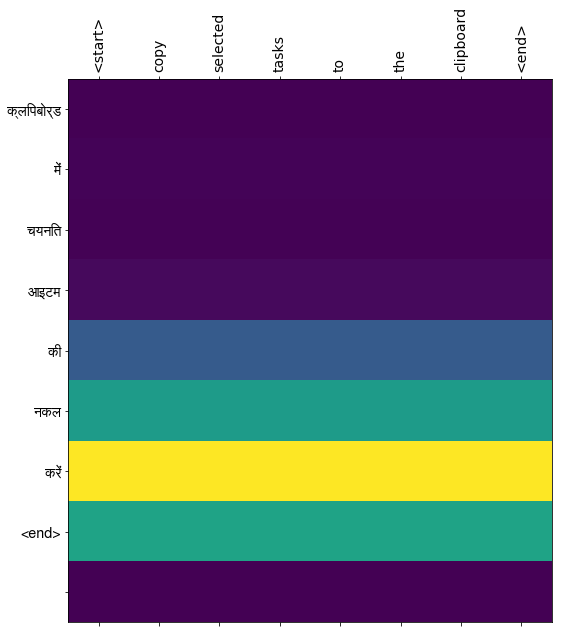

In [19]:
translate('copy selected tasks to the clipboard', encoder, decoder, max_length_inp, max_length_tar)

In [20]:
for n in range(10):
    data_prep.printSentence(X_all[n], en_idx2word_all)
    print('\n')
    data_prep.printSentence(Y_all[n], hi_idx2word_all)
    print('\n')

file 

फाइलः 

loan which has became bad of recovery 

ऋण जो <ukn> हो चुका है 

and said <ukn> i 've read your book 

और मुझसे बोली <ukn> मैंने तुम्हारी किताब पढी है 

another <ukn> story 

अनदर <ukn> स्टोरी 

copy selected tasks to the clipboard 

क्लिपबोर्ड से चयनित कार्य की नकल लें 

if your system does not have a vga port please skip this test 

यदि आपके तंत्र में <ukn> पोर्ट नहीं है तो इस जाँच को छोड दें 

invalid network address 

अवैध संजाल पता 

this is a supervised user managed <ukn> <ukn> 

यह पर्यवेक्षित <ukn> <ukn> द्वारा प्रबंधित किया जाता है 

the girl and some people took <ukn> to <ukn> nursing home 

वह लडकी और कुछ लोग आशु को <ukn> निजी अस्पताल ले गए 

and 26 march 2002 on the prevention of terrorism bill 2002 

और आतंकवाद निवारण विधेयक 2002 पर 26 मार्च 2002 को 



In [21]:
encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  5000400   
_________________________________________________________________
unified_gru (UnifiedGRU)     multiple                  3459072   
_________________________________________________________________
unified_gru_1 (UnifiedGRU)   multiple                  6297600   
Total params: 14,757,072
Trainable params: 9,756,672
Non-trainable params: 5,000,400
_________________________________________________________________


In [22]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      multiple                  5000400   
_________________________________________________________________
unified_gru_2 (UnifiedGRU)   multiple                  6604800   
_________________________________________________________________
unified_gru_3 (UnifiedGRU)   multiple                  6297600   
_________________________________________________________________
dense (Dense)                multiple                  51254100  
_________________________________________________________________
attention (Attention)        multiple                  2100225   
Total params: 71,257,125
Trainable params: 71,257,125
Non-trainable params: 0
_________________________________________________________________


In [0]:
X_test = X_all[50000:55000]
Y_test = Y_all[50000:55000]

In [0]:
X_test_sen = []
Y_test_sen = []

sents = []
for n in range(len(X_test)):
  sent_X = ' '.join(en_idx2word_all[X_test[n][i]] for i in range(len(X_test[n])))
  sent_Y = ' '.join(hi_idx2word_all[Y_test[n][i]] for i in range(len(Y_test[n])))
  X_test_sen.append(sent_X.strip())
  Y_test_sen.append(sent_Y.strip())


In [25]:
(len(X_test_sen), len(Y_test_sen), X_test_sen[200], Y_test_sen[200])

(5000,
 5000,
 'could not show help for <ukn> s”',
 '<ukn> s” के लिए मदद नहीं दिखा सका')

In [0]:
for n in range(len(X_test)):
  X_test[n] = [en_word2idx_all['<start>']] + X_test[n] + [en_word2idx_all['<end>']]
test_input_tensor = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                                maxlen=max_length_inp,
                                                                padding='post')


In [27]:
%%time
import codecs
test_file = '/content/gdrive/My Drive/W266/Project/test_results.txt'
fp = codecs.open(test_file, encoding="utf-8", mode="w")

for i, test_sent in enumerate(X_test_sen):
  res, _, _ = evaluate(test_sent, encoder, decoder, max_length_inp, max_length_tar)
  fp.write(test_sent)
  fp.write('\t\t')
  fp.write(Y_test_sen[i])
  fp.write('\t\t')  
  fp.write(res.strip().rsplit(' ', 1)[0])
  fp.write('\n')
  
fp.close()
  

CPU times: user 31min 34s, sys: 3min 4s, total: 34min 39s
Wall time: 32min 50s


In [31]:
import re
file_contents = []

with codecs.open(test_file, encoding="utf-8", mode="r") as fp:
  i = 0
  line = fp.readline()
  while len(line.strip()) > 0:      
      comps = re.split(r'\t+', line.rstrip('\n'))
      if (len(comps) > 2):
        file_content = [comps[1], comps[2]]
        file_contents.append(file_content)
        line = fp.readline()
      else:
          print(line)
          line = fp.readline()

      i = i + 1
      
      
print(len(file_contents))

5000


In [0]:
import score;

In [33]:
print(score.getBlueScore(file_contents))

0.4046282918221432
